# mSSA Running Example

In this notebook, we showcase the core  functionalities of the **mSSA** on both Synthetic and Real world dataset



### To run this test, you need:

**(1)** our mSSA package 

**(2)** numpy, pandas and matplotlib packages installed


### To install mSSA package, you need:

**(1)** download mSSA package (zip)

**(2)** open the conda, change dir to mSSA-folder  

**(3)** use ``pip install .`` to load the mSSA package

In [1]:
# Import the packages
from mssa.mssa import mSSA
import pandas as pd
import matplotlib.pyplot as plt
import io
import numpy as np

## Dataset

The dataset we will be using is a real water storage (cm). Not synthetically generated from a time-varying mean that is a mixture of harmonics, trend, and a time-varying variance that is generated via a mixture of harmonics.

Two files are in the `SSA` folder:

**(1)** `data.csv`: which we will use as our *training* set in the origin 174 rows, which has total 195 rows

**(2)** `data.csv`: which we will use as our *test* set for forecasts, which 21 rows.

**(3)** `data.csv`: the real column is real data.





In [2]:
data = pd.read_csv("data.csv", index_col = None)
data

,Month,test,real
0,2003/1/1,5.294270,5.294270
1,2003/2/1,8.509197,8.509197
2,2003/3/1,7.921764,7.921764
3,2003/4/1,NaN,5.346835
4,2003/5/1,-7.218922,-7.218922
...,...,...,...
190,2018/11/1,NaN,-3.478465
191,2018/12/1,NaN,-6.483819
192,2019/1/1,NaN,-3.037491
193,2019/2/1,NaN,0.547982


Our time series data consist of 6 columns, namely:

**(1) Month**: (date) this column represent the time index

**(2) test:** (float) Where several observation of the time series are masked, and a 21 series time-data is masked.

**(3) real:** (float) Where the observation of the time series are stored

In this example, we will use the `test` column, where the data are missing, and we will estimate the imputation and forecasting accuracy by comparing them with the real underlying mean. 

### Train mSSA model
Now, we will train the mSSA model, which allows for retreiving predicted values for entries that are: 

**(1)** At a future time step (i.e. forecasting), 

**(2)** Missing/corrupted by noise (i.e. imputation)

In addition to that, it will also estimate the underlying time-varying variance of the time series, which allow users to produce upper and lower bound for their prediction.  

Let's train the model on the column **train**. Note that we set the `fill_in_missing` to True, this option interpolate some of the missing values by forward filling the missing observation, followed by a backward filling. Setting this option to True can help in some datasets.  

In [3]:
model = mSSA(fill_in_missing = True)
# model
model.update_model(data.loc[:174,['test']])

### Imputation predictions

#### Simple example

Before imputing the data, let's look at the value of `test` at time 174 in the dataframe. 

In [4]:
data.loc[174,'test']

nan

We can see that the value is missing at time 174. Let's check what was the underlying mean of our data at the same time, which we can get from the dataframe.

In [5]:
data.loc[174,'real']

5.853517957

In [6]:
df = model.predict('test',174)
df

,Mean Predictions,Lower Bound,Upper Bound
174,9.030859,6.479111,11.582607


Let's see what mSSA produces using the function `predict()`. Idealy, we would like mSSA to *predict* the value `9.030859` for `test` at time = 174. 

The predicted value is `9.03` with an lower bound of `6.48` and upper bound of ~ `11.58`. The confidence interval is fairly big! which indicate that the index estimate a fairly high variance at this point. Let's check the underlying variance from our data table. 

Which is indeed a big variance that justifies the big confidence interval.

Let's now use the `predict()` function again to plot the first 100 imputed points, along with the observations `test` and the underlying latent mean.

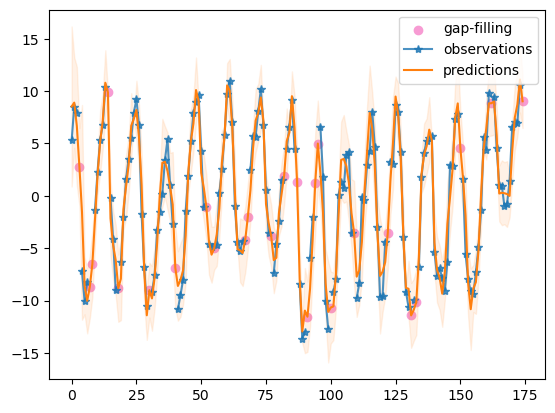

In [7]:
tempdata = data['test'][:175]
df = model.predict('test',0,174)
df['time'] = np.arange(175)
plt.figure()
plt.scatter(tempdata[tempdata.isna()].index, df['Mean Predictions'][np.isnan(tempdata)], label = 'gap-filling', color = '#F79BD3')
plt.plot(df['time'], data['test'][:175],'-*', label = 'observations', alpha = 0.8)
plt.plot( df['Mean Predictions'], label = 'predictions')
plt.fill_between(df.index, df['Lower Bound'],df['Upper Bound'], color = 'tab:orange', alpha = 0.1)
plt.legend()
plt.show()

Note that the predictions closely follow the underlying mean, even though 30% of the data is missing. Note also that the upper and lower bound estimates almost always envelop the observations. 

#### imputation Accuracy
To estimate the accuracy of our predictions, let's predict the first 174 points and compare the predictions to the real underlying mean.  

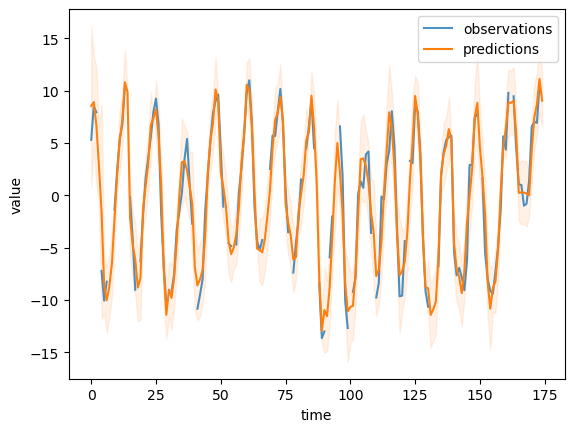

In [8]:
N = 175

df = model.predict('test',0,N-1)
df['time'] = np.arange(N)
plt.figure()
plt.plot(df['time'][:N], data['test'][:N], label = 'observations', alpha = 0.8)
plt.plot( df['Mean Predictions'], label = 'predictions')
plt.fill_between(df.index, df['Lower Bound'],df['Upper Bound'], alpha = 0.1, color = 'tab:orange', )

plt.ylabel('value')
plt.xlabel('time')
plt.legend()

The mean Square Error (MSE) is:

In [9]:
def NSE(y_obs, y_sim):
    y_obs_mean = y_obs.mean()
    sum1 = 0
    sum2 = 0
    for i in range(len(y_obs)):
        sum1 = sum1 + ((y_obs.iloc[i] - y_sim.iloc[i]) ** 2)
        sum2 = sum2 + ((y_obs.iloc[i] - y_obs_mean) ** 2)
    NSE = 1 - (sum1/sum2)
    return NSE

print ('imputation accuracy (MSE):',np.mean(np.square(data['real'][:N]-df['Mean Predictions'][:N])))
print ('imputation accuracy (NSE):',NSE(data['real'][:N], df['Mean Predictions'][:N]))
print ('imputation accuracy (R2):',np.corrcoef(data['real'][:N], df['Mean Predictions'])[0,1])

imputation accuracy (MSE): 2.959612215783514
imputation accuracy (NSE): 0.9311028468084923
imputation accuracy (R2): 0.9650840612968608


### Forecasting

In this example, we will forecast the next 21 points in our time series. That is, we will predict the value of `test` from time = 175 to time = 195. We will then compare the result with the underlying mean.

First we will load the test dataset to compare our predictions with it

In [10]:
data_test = pd.read_csv('data.csv').iloc[:195]
means = data['test']
data_test['time'] = np.arange(195)

In [11]:
model = mSSA(fill_in_missing = True)
# model
model.update_model(data.loc[:175,['test']])

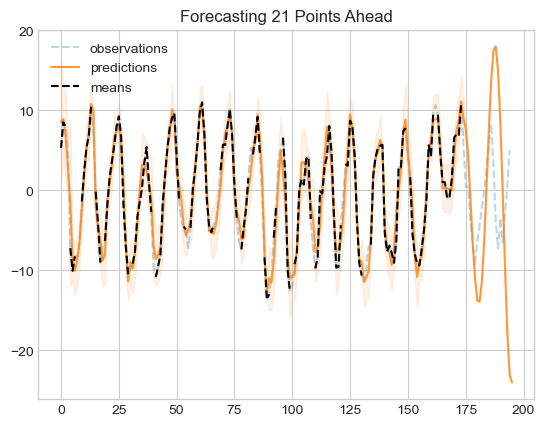

In [14]:
plt.style.use('seaborn-whitegrid')
df = model.predict('test',0,195)
plt.figure()
plt.plot(data_test['time'], data_test['real'],'--', label = 'observations', alpha = 0.3)
plt.plot(df['Mean Predictions'], label = 'predictions', alpha = 0.8)
plt.fill_between(df.index, df['Lower Bound'],df['Upper Bound'], alpha = 0.1, color = 'tab:orange', )
plt.plot(data_test['time'], data_test['test'],'--k', label = 'means', alpha = 1.0)

plt.title('Forecasting 21 Points Ahead')

plt.legend()